# Machine Learning: Exercise session 03

In this exercise session we will focus mainly on model assessment. You will learn how to use and apply some of the error estimation techniques seen in class, using scikit-learn (parts 1 and 2).

To illustrate these techniques in context, we will continue where we left out in exercise session 01, with the housing dataset. You can export and use your resulting, cleaned, dataframe from the first session, or you can download it on moodle in this week's section (with the cleaning and feature engineering from the first session already performed).

The third part of this notebook will introduce scikit-learn's Pipelines, which are a very useful tool that can be used, among other things, to avoid validation overfitting during cross-validation.

Due to this last part making the practical part a bit longer, there will be no "theoretical" exercise this week.

## 0. Introduction and Setup

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

Import the clean housing dataset with `pd.read_csv` and take a quick look at it, to verify that it is in the desired shape (display the dataframe, check its "infos").

In [49]:
df=pd.read_csv("housing_clean.csv")

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   longitude             20433 non-null  float64
 1   latitude              20433 non-null  float64
 2   housing_median_age    20433 non-null  float64
 3   median_income         20433 non-null  float64
 4   median_house_value    20433 non-null  float64
 5   rooms_per_bedroom     20433 non-null  float64
 6   rooms_per_household   20433 non-null  float64
 7   people_per_household  20433 non-null  float64
 8   ocean_proximity_enc   20433 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Separate the dataframe into the features `X` and the target variable `y`: (remember, we want to predict the median house value, given the other variables)

In [51]:
X = df[["longitude","latitude", "housing_median_age","median_income","rooms_per_bedroom","rooms_per_household","people_per_household","ocean_proximity_enc"]]
Y = df[["median_house_value"]]

## 1. Fitting KNN and expected error

In [52]:
from sklearn.neighbors import KNeighborsRegressor

The goal of the following sections will not only be to use a k-Nearest neighbors regression model in order to predict the expected median household values, based on the other features, but also to assess how our model is performing, that is, its expected prediction error.

To begin with, import the same KNN regression model that you briefly used in the first exercise session, and fit it on the whole dataset for the desired prediction task. Use as a hyper-parameter `k=1` neighbors.

In [53]:
knn = KNeighborsRegressor(n_neighbors=1)


In [54]:
knn.fit(X,Y)

KNeighborsRegressor(n_neighbors=1)

In [55]:
predicted=knn.predict(X)

Now, evaluate its root mean squared error using `X` and `y`.

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
mean_squared_error(Y,predicted)

0.0

What do you observe? What does that say probably say about the model? Does that mean that the model is performing well, you think?
*There's absolutely no difference between the true value and the predicted one. Indeed, we didn't split the data between training data and testing data. Moreover, we chose k=1, which fit each datapoint depending on its own value.The model is therefore overfitting. The model do not perform well.*

### 1.1. Train-test split

Now, separate the data into `X_train` `y_train` and `X_test` `y_test`, and fit a KNN regressor on the training set

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# fill out the ??
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 42)

In [60]:
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=1)

Check its RMSE both on the training and on the test set, do you observe something that you expected?

*Yes, the prediction on the testing data set has a bigger RMSE, as it's a prediction done on unseen data.*

In [61]:
mean_squared_error(y_train,knn.predict(X_train))

0.0

In [62]:
mean_squared_error(y_test,knn.predict(X_test))

5899838962.953755

You've learned about the Bias-Variance tradeoff during the last lecture. Does the model suffer from too much bias or too much variance? Does that mean that it is too "flexible", or not enough?

*The model has too much variance, not enough bias. It means it is too flexible*

### 1.2. Cross-validation

When fitting a model, we are interested in its expected generalization error (the expected error on unseen data).
In order to estimate this expected error, a more stable way to estimate it than with a train-test split is to use cross-validation.

Declare a new KNN regressor instance with the same hyper-parameter as before, and estimate its expected generalization error with 10 folds cross-validation on `X` and `y`.

Print the average generalization RMSE for each fold as well as the cross-validation error estimate.


_Remark:_ during fitting sklearn maximizes "scores" instead of minimizing losses, that is why we specify `scoring="neg_mean_squared_error"` below, as we maximize the negative MSE instead of minimizing the MSE.

In [63]:
from sklearn.model_selection import cross_val_score

In [64]:
knn = KNeighborsRegressor(n_neighbors=1)
CVscores = cross_val_score(knn, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [65]:
print(CVscores)

[-5.57453479e+09 -4.97277254e+09 -5.75870225e+09 -5.92715403e+09
 -5.17651373e+09 -5.47327643e+09 -5.61825365e+09 -5.51132078e+09
 -4.85600524e+09 -5.52123409e+09]


In [66]:
np.mean(CVscores)

-5438976752.699072

Note in `cross_val_score` you can simply specify the number of folds with the argument `cv=10`. By default, sklearn splits the data equally into the specified number of folds without shuffling it first. This behaviour might be useful when, for example, some time dependence between observations needs to be kept for specific models. However, if we assume that the observations are independent, it might be a better idea to shuffle observations (rows) before splitting, to avoid imbalances within folds, created by any kind of prior implicit sorting of the observations.

You can control the splitting method and, in particular, shuffle the data prior to splitting in folds, by specifying a [KFold object](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) instead of a simple number for the `cv` argument.

Repeat the cross-validation estimation by, this time, shuffling the data for the folds split. Do you notice any difference with the estimated RMSEs for each fold? If yes, why do you think (speculate) it might be?


In [67]:
from sklearn.model_selection import KFold

In [68]:
knn = KNeighborsRegressor(n_neighbors=1)
folds = KFold(n_splits=10 , shuffle=True, random_state=1)
CVscores = cross_val_score(knn, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [69]:
print(CVscores)

[-5.57453479e+09 -4.97277254e+09 -5.75870225e+09 -5.92715403e+09
 -5.17651373e+09 -5.47327643e+09 -5.61825365e+09 -5.51132078e+09
 -4.85600524e+09 -5.52123409e+09]


In [70]:
np.mean(CVscores)

-5438976752.699072

*There seems to be no difference. This indicates that there was no specific sorting during data collecting.*

## 2. Hyper-Parameter tuning and Cross-validation

In the first part, we "arbitrarily" chose a hyper-parameter value for our model. However, this value might not be optimal. Usually, we want to compare the model's expected error for a range of different possible hyper-parameters, in order to choose the best one for the task at hand. (Remember the optimal value depends on the specific data we try to model, and there cannot be a "best" hyper-parameter value overall, this is often called the *no free lunch theorem*.)

In sklearn, [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) performs a grid-search over the given range of hyper-parameter values, by estimating the cross-validation error for each value in the given grid.

In [71]:
from sklearn.model_selection import GridSearchCV, KFold

First, instanciate a new kNN regressor (no need to specify a k value), and specify the grid of hyper-parameter values in a dictionary of the form `{"hyper_param_name" : values_to_try}`.

Choose equally spaced values between $1$ and $49$, with an increment of $2$ as a grid of values to try.

In [84]:
knn = KNeighborsRegressor()

hyper_parameters = {"n_neighbors" : [int(k) for k in np.linspace(1,49,25)]}

Now perform the Grid-search with 10-fold cross-validation, to estimate the model's generalization error for the chosen grid of k values. Don't forget to shuffle the data for the fold split.

_Hint:_ `GridSearchCV` is an object, you need to instanciate it and fit it (like a ML model).

In [79]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [85]:
knnCV = GridSearchCV(estimator=knn, param_grid=hyper_parameters, scoring="neg_mean_squared_error",
                       cv=KFold(n_splits=10, shuffle=True, random_state=1))

knnCV.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             scoring='neg_mean_squared_error')

In [88]:
knnCV.cv_results_

{'mean_fit_time': array([0.06682136, 0.0662147 , 0.0723985 , 0.06464229, 0.06323411,
        0.06363385, 0.07193286, 0.06434839, 0.07014589, 0.06555479,
        0.07264125, 0.06116204, 0.06642797, 0.06821699, 0.06363013,
        0.06412535, 0.06253593, 0.06375151, 0.06692545, 0.0625416 ,
        0.06166499, 0.06643288, 0.06366205, 0.06383064, 0.06382537]),
 'std_fit_time': array([0.00915406, 0.00506718, 0.00811899, 0.00595648, 0.00135734,
        0.00273972, 0.00780623, 0.00222924, 0.01296033, 0.01713852,
        0.02194152, 0.00148549, 0.00865112, 0.00720792, 0.00306745,
        0.00428663, 0.00299957, 0.00238581, 0.00660402, 0.00277193,
        0.00141775, 0.00539819, 0.00246838, 0.00393905, 0.00325306]),
 'mean_score_time': array([0.05516224, 0.07880034, 0.10831292, 0.09732742, 0.10900695,
        0.11669595, 0.15234559, 0.12743998, 0.14814522, 0.16304486,
        0.17573009, 0.14239872, 0.16744721, 0.17236338, 0.15659919,
        0.16377399, 0.16500278, 0.17490606, 0.18600583, 0.17

Now, using the `GridSearchCV` results that you inspected, extract the k value yielding the "best" (lowest) MSE estimate

(Again fill out the `??` below)

In [106]:
resCV = knnCV.cv_results_

test_MSEs = -resCV['mean_test_score']
std_test_MSEs = resCV['std_test_score']
# k_grid = resCV[??].data

index_best = np.argmin(resCV['rank_test_score']) # index of the k value with the lowest MSE estimate
best_k = index_best*2+1

In [113]:
resCV['param_n_neighbors'][0]

1

In [104]:
std_test_MSEs[index_best]

124709916.75532416

Now extract the more parsimonious k value obtained by the "one standard error rule" seen in class.

_Hint_: You might first need to answer this question: *Are larger or smaller k values yielding a more parsimonious model (low "flexibility" and variance)?*

In [110]:
max_distance_to_best= test_MSEs[index_best]+std_test_MSEs[index_best]
smaller_than_one_std_to_best=[k for k in range(index_best,25) if test_MSEs[k]<max_distance_to_best]

one_std_rule_best_k = smaller_than_one_std_to_best[-1]*2+1

In [111]:
one_std_rule_best_k

19

To better visualize how the expected error varies as a function of the hyper-parameter k, we can construct a MSE plot with standard deviations from the `GridSearchCV`. It is also nice to highlight the two important k values discussed just above (with vertical lines for example).

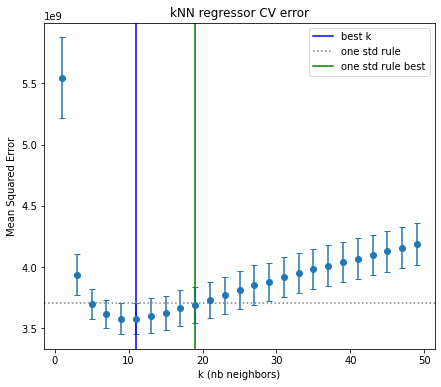

In [123]:
plt.figure(figsize=(7,6))
plt.errorbar(x=[int(k) for k in np.linspace(1,49,25)], y=test_MSEs, yerr=std_test_MSEs, fmt='o', capsize=3)

plt.axvline(best_k, color="blue",label="best_k")#vertical line at the k yielding minimum CV MSE
plt.axhline(max_distance_to_best, ls='dotted', color="grey",label='one_std_rule')#horizontal line for the upper limit
plt.axvline(one_std_rule_best_k, color="green",label="one_std_rule_best")#vertical line at best k value according to 1 std err rule


plt.title("kNN regressor CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.legend(('best k','one std rule','one std rule best'))
plt.show()

To conclude, how does the expected generalization error of the model with the newly selected k value compare to our initial k choice, prior to cross-validation based selection?

And for the other k values, how to you think the training error compares to the CV error. You can compare them by adding the training error as a function of the hyper-parameter value to the plot above. (*Hint: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can return the training scores, but it is more expensive computationally. You can also compute them yourself easily on X and y by iterating over the k_grid.*)

*Our initial $k$ value was by far the worst one, as displayed on the plot*

You can now fit the model, with the newly selected k value to the whole dataset. This will be the final kNN model, chosen based on empirical evidence :)

In [119]:
knn_final = one_std_rule_best_k
knn = KNeighborsRegressor(n_neighbors=knn_final)
knn.fit(X,Y)

KNeighborsRegressor(n_neighbors=19)

_Remark:_ KNN was used as an example in this session, but we could also do the same with any other machine learning model.

## 3. Pipelines and cross-validation

***This third part is not mandatory for the hand-in***

### 3.1 Motivation

There is one essential detail that has been left-out in the first two parts of this notebook.
As kNN relies on euclidean distance to select the nearest points, it is always better to work with standardized data (each variable rescaled to be centered at 0 and have unit variance). That way the same distance along each feature axis is proportional for each variable.

As you've seen in the first week's tutorial, you can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to rescale the variables.

When you leave some validation/test data out to evaluate your model, it is best practice to **not use it for any type of estimation**, to avoid having a biased error estimate (as, otherwise, you already "took" some information from the validation data). This also holds for estimating the mean and standard deviation of variables, with the `StandardScaler`.

Here is an example of how to scale the data properly, in case of a train-test split, without overfitting the test set:

In [45]:
from sklearn.preprocessing import StandardScaler

#Create the scaler:
scaler = StandardScaler()

#Estimate the mean and variances for each variable on the training set only:
scaler.fit(X_train)

print("Original means:", scaler.mean_)
print("Original Variances:", scaler.var_)

#Scale the training and test features, using the previously estimated means and variances
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

Original means: [-119.58051328   35.64056895   28.61501285    3.87069684    4.98214201
    5.42498593    3.10022784    1.17117338]
Original Variances: [  4.02337913   4.56298874 158.175595     3.60151825   1.37041922
   5.56867348 135.72595174   2.02796139]


We could then fit our kNN model on the scaled training set and evaluate it on the test set, without having "cheated", by using information from the test set in our estimations.

If you now think about estimating the error using cross-validation, you'll quickly realize that not overfitting with the scaler gets a bit more complicated, as we need to perform the above procedure separately for each fold, before fitting the model. That is when Pipelines come into play.

### 3.2. Cross-validation with Pipelines

In a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) you can define sequentially, all the steps of your transformation + fitting process. For example standard scaling + kNN. The syntax is the following (complete the ??): 

_Hint_: each step in the pipeline is defines as a tuple: `("desired_step_name", Transformer_or_predictor_object)`

In [44]:
from sklearn.pipeline import Pipeline

In [46]:
knn_pipe = Pipeline([("scaler", scaler),
                     ("kNN", knn)])

You can then fit the entire Pipeline on the training set, and predict on the test set, as if it was a single model:

In [47]:
knn_pipe.fit

<bound method Pipeline.fit of Pipeline(steps=[('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])>

Now repeat the grid-search (section 2, except the training error question) by using the new Pipeline instead of the simple kNN as a model.

_Hint 1:_ There shouldn't be too many changes in the code.

_Hint 2:_ You'll need to add the pipeline step name before the parameter name for the grid in `GridSearchCV`. (i.e. replace `"n_estimators"` by `"kNN__n_estimators"`).

In [ ]:
#Declare Pipe and grid:


In [ ]:
#Declare and fit the grid search:


In [ ]:
#Compute "best" k value and its index:


In [ ]:
#compute best k based on one std error rule:


In [ ]:
#Plot the grid-search results:


In [ ]:
#Fit the final model:
